In [ ]:
pip install  pylops==1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 KB 2.0 MB/s eta 0:00:00


In [28]:
import numpy as np
#import pylops
#from pylops.optimization.sparsity import ISTA
#from pylops.optimization.sparsity import FISTA
from math import log
import matplotlib.pyplot as plt
import numpy
from scipy.stats import pearsonr
import pandas as pd
import time

##Classe

In [30]:
'''
Ce code définit les classes qui vont être utilisées par la suite dans le projet 
'''


#la Classe random contient les fonctions qui simulent les variables aléatoires qui seront utilisée pour étudier les données simulés.

print("test")
class random:  
    def matrix_normal(n,p,mu=0,sigma=1):  # n est le nombre de lignes et p le nombre des colonnes, mu est la moyenne et sigma est l'écart type
        return (np.random.randn(n,p)*(sigma**2))+mu
    def vect_normal(n,mu=0,sigma=1):
        return (np.random.randn(n)*(sigma**2))+mu
    def beta(a,s,n): # s et a sont à préciser tel que s= 0,1*p et n> 2*s*log(p/2) pour commencer on peut utilisr a=1
        return a*(np.random.binomial(1,s/n , size=(n,)))
    def outcome(n,p,a,s,mu=0,sigma=1):
        X=random.matrix_normal(n,p,mu,sigma)
        beta=random.beta(a,s,p)
        epsilon=random.vect_normal(n,mu,sigma)
        Y=X @ beta+epsilon
        return Y,X,beta,epsilon


#la classe algo contient les algorithmes qui seront utilisés nottament ISTA et IHT
class algo:


    def HardThreshold(x,lamda):
        return x*(np.abs(x)>=lamda)
    def SoftThreshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)


    def IHT(X, Y,beta=np.zeros(1) ,C=0.9,step=0.0001,max_iterations=3000,lamda=0.1, tol=1e-6):
        n,m=X.shape
        Z,Beta=np.zeros(m),np.ones(m)
        loss=[]
        cost=[]
        check_vect=np.zeros(m)
        test=np.zeros(1)
        if np.array_equal(beta, test, equal_nan=False):
          beta=Beta.copy()
          print('We are in the unknow beta case,the cost function is not significant')
        start_time = time.time()        
        for i in range(max_iterations):
            Z=Beta+(step*(X.T)@(Y-X@Beta))
            Beta=algo.HardThreshold(Z, lamda)
            cost.append(np.linalg.norm(-beta+Beta))
            lamda*=C
            loss.append(Beta[-1]-Beta[-2])
            if np.linalg.norm(Beta -check_vect ) < tol:
                break
        end_time = time.time()
        time_taken = end_time - start_time
        print("IHT execution time :", time_taken, "seconds")

        return Beta,cost,loss

    def ISTA(X, Y,beta=np.zeros(1) ,step=0.0001,max_iterations=3000,lamda=0.01, tol=1e-6):
        n,m=X.shape
        Z,Beta=np.zeros(m),np.ones(m)
        check_vect=np.zeros(m)
        test=np.zeros(1)
        cost=[]
        loss=[]
        if np.array_equal(beta, test, equal_nan=False):
          beta=Beta.copy()
          print('We are in the unknow beta case,the cost function is not significant')
        start_time = time.time()
        for i in range(max_iterations):
            Z=Beta+(step*(X.T)@(Y-X@Beta))
            Beta=algo.SoftThreshold(Z, lamda)
            cost.append(np.linalg.norm(-beta+Beta))
            loss.append(Beta[-1]-Beta[-2])
            if np.linalg.norm(Beta -check_vect ) < tol:
                break
        end_time = time.time()
        time_taken = end_time - start_time
        print("ISTA execution time :", time_taken, "seconds")
        return Beta,cost,loss

test


##données simulées


Les paramètres: n pour le nombres d'itération qu'on souhaite fixer pour l'execution des différents algorithmes 

In [9]:
n=100
alpha= numpy.linspace(0,0.1,100)

les paramètres pour définir la taille et les caractéristiques des vecteurs qui représentent les données simulées. p et s représentent la taille de la matrice X qui simule un vecteur normal de paramètres $E$[X]=1 et $V$[X]=0. 
Quant à s et a sont les paramètres qu'il faut préciser pour la simulation de la variable $\beta$ qui simule un vecteur aléatoire de lois binomiale. s et a sont à préciser tel que s= 0,1*p et p> 2*s*log(n/2). $\alpha$ est un vecteur qui contient les différentes valeurs de alpha qu'on va utiliser pour exécuter les différents algorithmes. 

In [11]:
k=1000
p=2000
a=1
s=0.1*2000
alpha= numpy.linspace(0,0.1,100)

In [12]:
Y,X,beta,epsilon=random.outcome(3000,4000,1,0.1*4000)
n=100

In [13]:
columns = ['alpha', 'distance euclidienne', 'algorithme']
df_ista = pd.DataFrame(columns=columns)
df_fista = pd.DataFrame(columns=columns)

##Data visualisation
Dans cette partie on essaye de représenter la fonction coût pour 100 valeurs différentes d'alpha. Dans un premier temps on fait la représentation pour l'algorithme ISTA et FISTA d'un coté.Dans un second temps on fait la repésentation des 2 courbes superposées. Cette visualisation permet de suggérer que l'algorithme FISTA converge plus rapidement. La section suivante vise à mener une étude statistique sur ces deux fonction de coût

ISTA execution time : 153.89541244506836 seconds


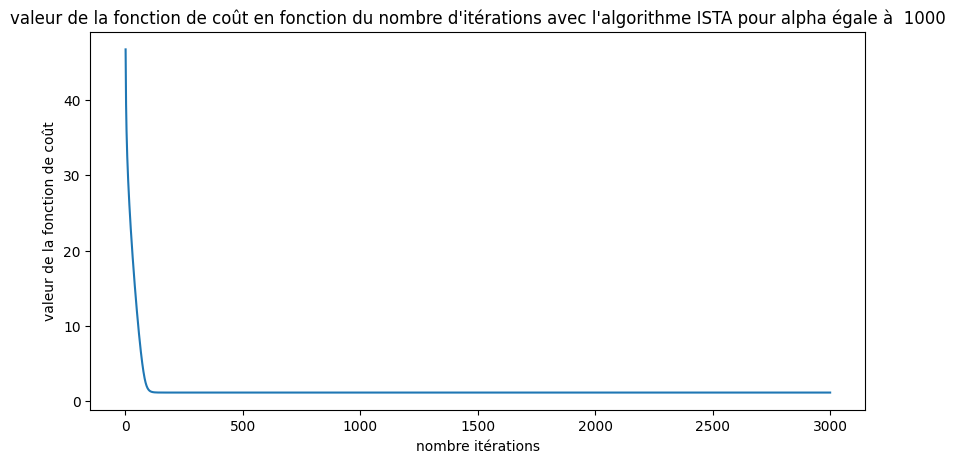

In [29]:
betahat_ista,cost_ista,loss_ista=algo.ISTA(X,Y,beta)
nbr_it = list(range(1,len(cost_ista)+1))
  
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,cost_ista)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

#ce graphique représente la vitesse de convergence en fonction du nombre d'itération de la fonction de coût de l'algorithme ISTA

In [36]:
C=0.88
step=0.0001
max_iterations=3000
lamda=1.3
tol=1

IHT execution time : 162.84171867370605 seconds


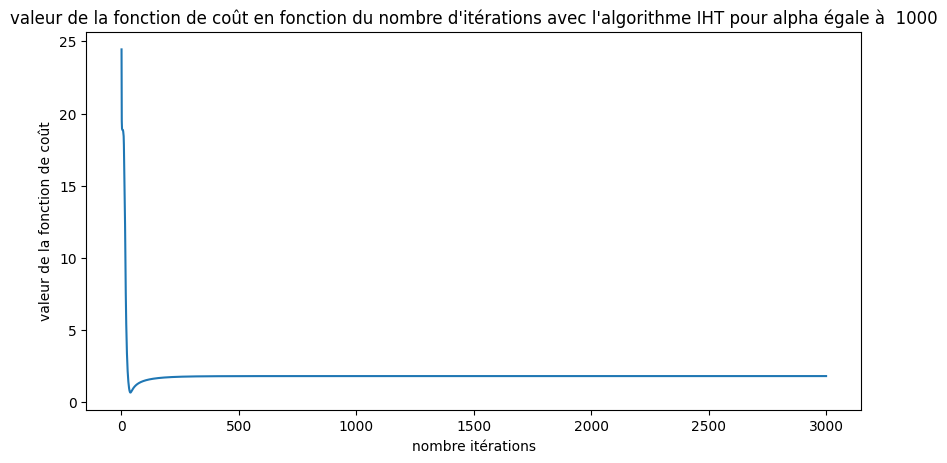

In [37]:
betahat_iht,cost_iht,loss_iht=algo.IHT(X, Y,beta ,C,step,max_iterations,lamda)
nbr_it_h = list(range(1,len(cost_iht)+1))
  
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it_h,cost_iht)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme IHT pour alpha égale à  {}".format(k))  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()


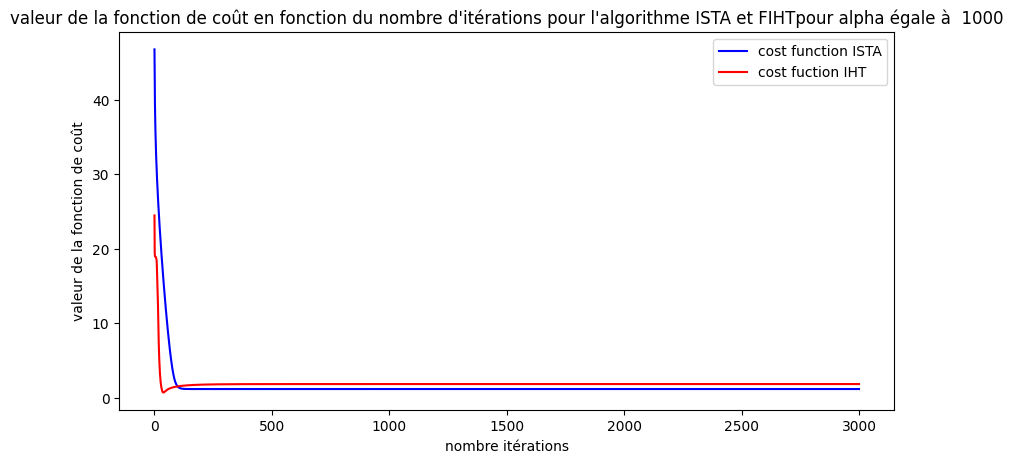

In [38]:
plt.figure(figsize=(10, 5), dpi=100)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations pour l'algorithme ISTA et FIHTpour alpha égale à  {}".format(k))
plt.plot(nbr_it,cost_ista, color='blue', label='cost function ISTA')
plt.plot(nbr_it_h,cost_iht, color='red',label='cost fuction IHT')
plt.legend(loc='upper right')
plt.show()




Ce tableau résume la distance euclidienne des deux algorithmes ISTA et FISTA

# Étude statistique des résultats
dans cette partie on essaye de calculer le coeficient de correlation entre la fonction de coût de l'algorithme ista et fista, ainsi que la pente des ces deux fonctions afin de montrer que la convergence de FISTA est plus rapide que celle de l'algorithme ISTA


In [39]:
#tentons le calcul du coefficient de Pearson
x=cost_ista
y=cost_fista
coeff_pearson,_ = pearsonr(x,y)
print("le pourcentage de corrélation entre .... : {}".format(coeff_pearson))

#97% de pourcentage de corrélation , cela signifie que les deux fonctions de coût de l'algorithme ISTA et FISTA sont quasiment équivalentes
#le calcul de la pente nous permet de montrer que la valeur ajoutée de FISTA est sur la vitesse de convergence
#je ne suis pas bien sûr de ce qu'on peut en faire mais je vais continuer à creuser

NameError: ignored

In [ ]:
#on peut faire un t-test aussi pour vérifier si ces 2 séries temporelles ont de fortes différences
#à valider avec Ilyes et Aziz

#calculons le slope des séries temporelles

slopeISTA = np.polyfit(nbr_it,cost_ista,1)[0]
print('la pente de la fonction de coût générée par ISTA vaut', slopeISTA)


slopeFISTA = np.polyfit(nbr_it,cost_fista,1)[0]
print( 'la pente de la fonction de coût générée par FISTA vaut', slopeFISTA)

#donc l'algorithme FISTA converge bien plus rapidement que l'algorithme IISTA puisque sa pente est plus grande 

la pente de la fonction de coût générée par ISTA vaut -116.49345747686354
la pente de la fonction de coût générée par FISTA vaut -38.794647138356616
